In [709]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from backtesting import Backtest, Strategy
import talib as ta
from datetime import timedelta

CRYPTO:
stop_loss_multiplier = 10
take_profit_multiplier = 20

FOREX:
stop_loss_multiplier = 4
take_profit_multiplier = 8

In [710]:
stock = yf.Ticker("BTC-GBP")
long_start = '2024-05-15'
long_end = '2024-08-14'
long_interval = '1H'
short_start = '2024-06-17'
short_end = '2024-08-14'
short_interval = '15m'

In [711]:
longer_period = 50
daily_ema_period = 100
daily_ema_offset = 1.0
stop_loss_ratio = 0.02
commission_percentage = 0.001
amount_invested = 1000
leverage = 1.00

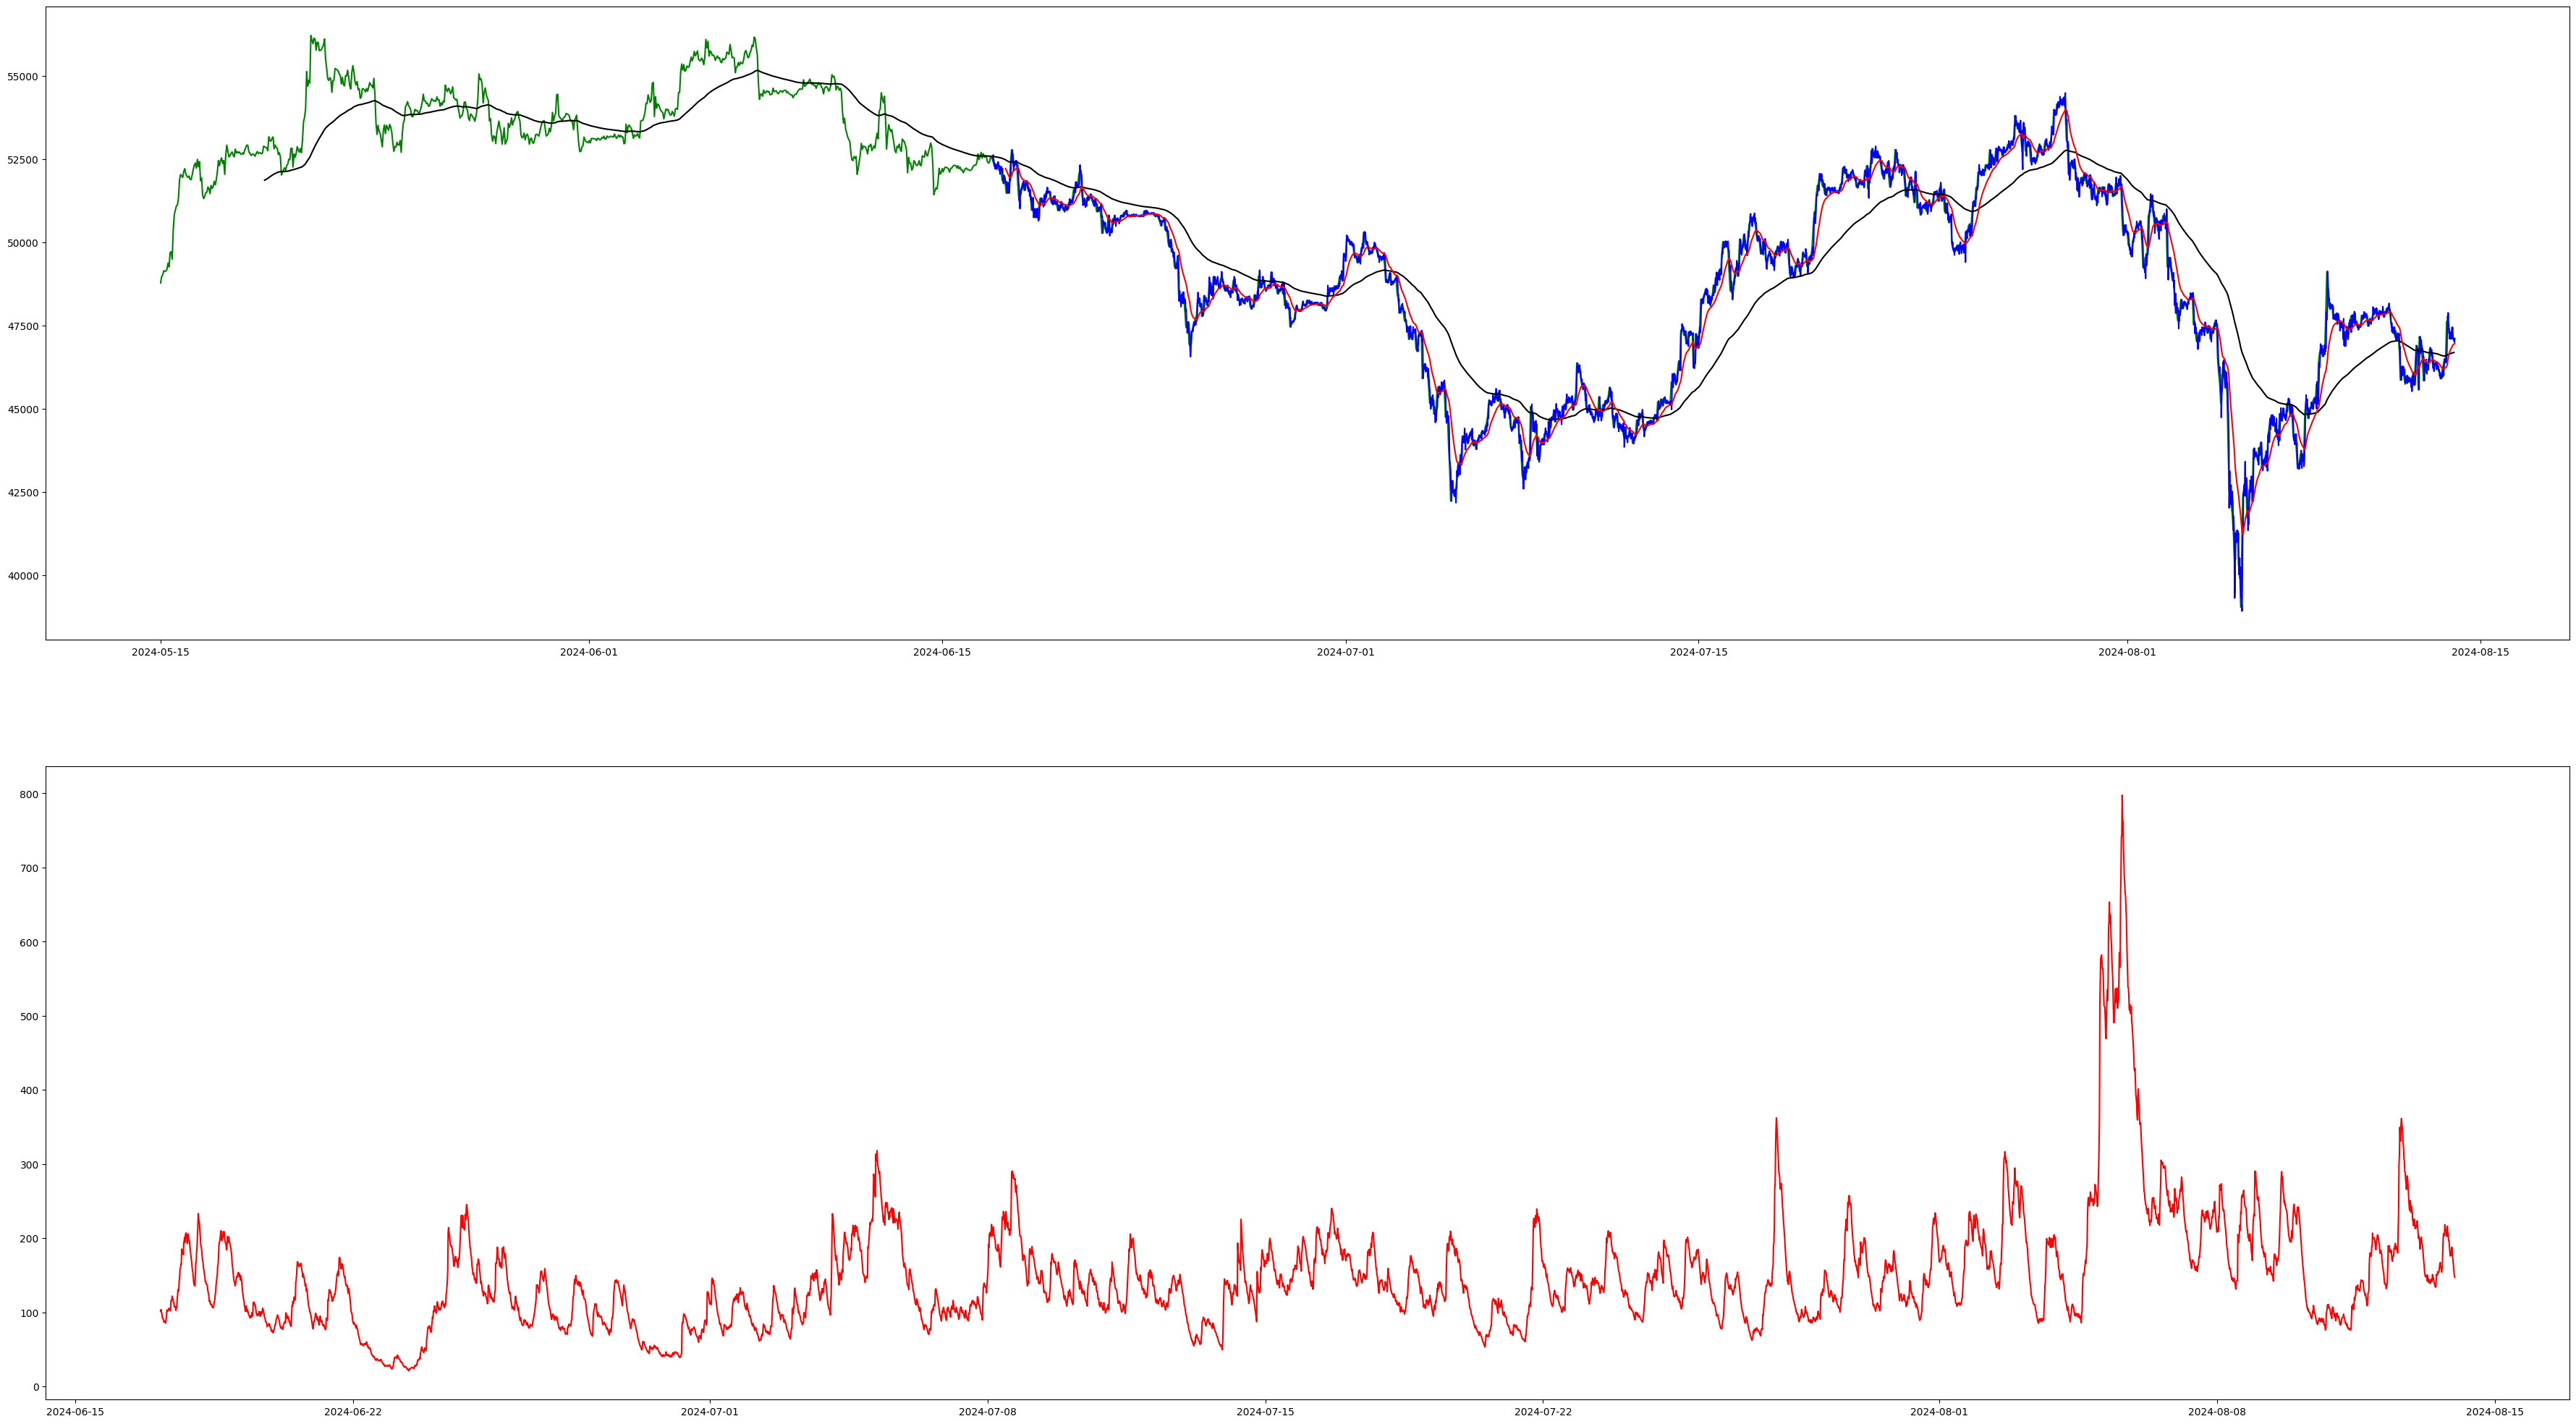

In [712]:
long_data = stock.history(interval=long_interval, start=long_start, end=long_end)
data = stock.history(interval=short_interval, start=short_start, end=short_end)
long_data['Daily EMA'] = ta.EMA(long_data['Close'], daily_ema_period) * daily_ema_offset
data['EMA'] = ta.EMA(data['Close'], longer_period)
data['Previous EMA'] = data['EMA'].shift()
data['Hourly Date'] = data.index.floor('h')
data['ATR'] = ta.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
figure, axis = plt.subplots(2, figsize=(45, 25))
axis[0].plot(long_data.index, long_data.Close, color='green')
axis[0].plot(data.index, data.Close, color='blue')
axis[0].plot(long_data.index, long_data['Daily EMA'], color='black')
axis[0].plot(data.index, data['EMA'], color='red')

axis[1].plot(data.index, data['ATR'], color='red')

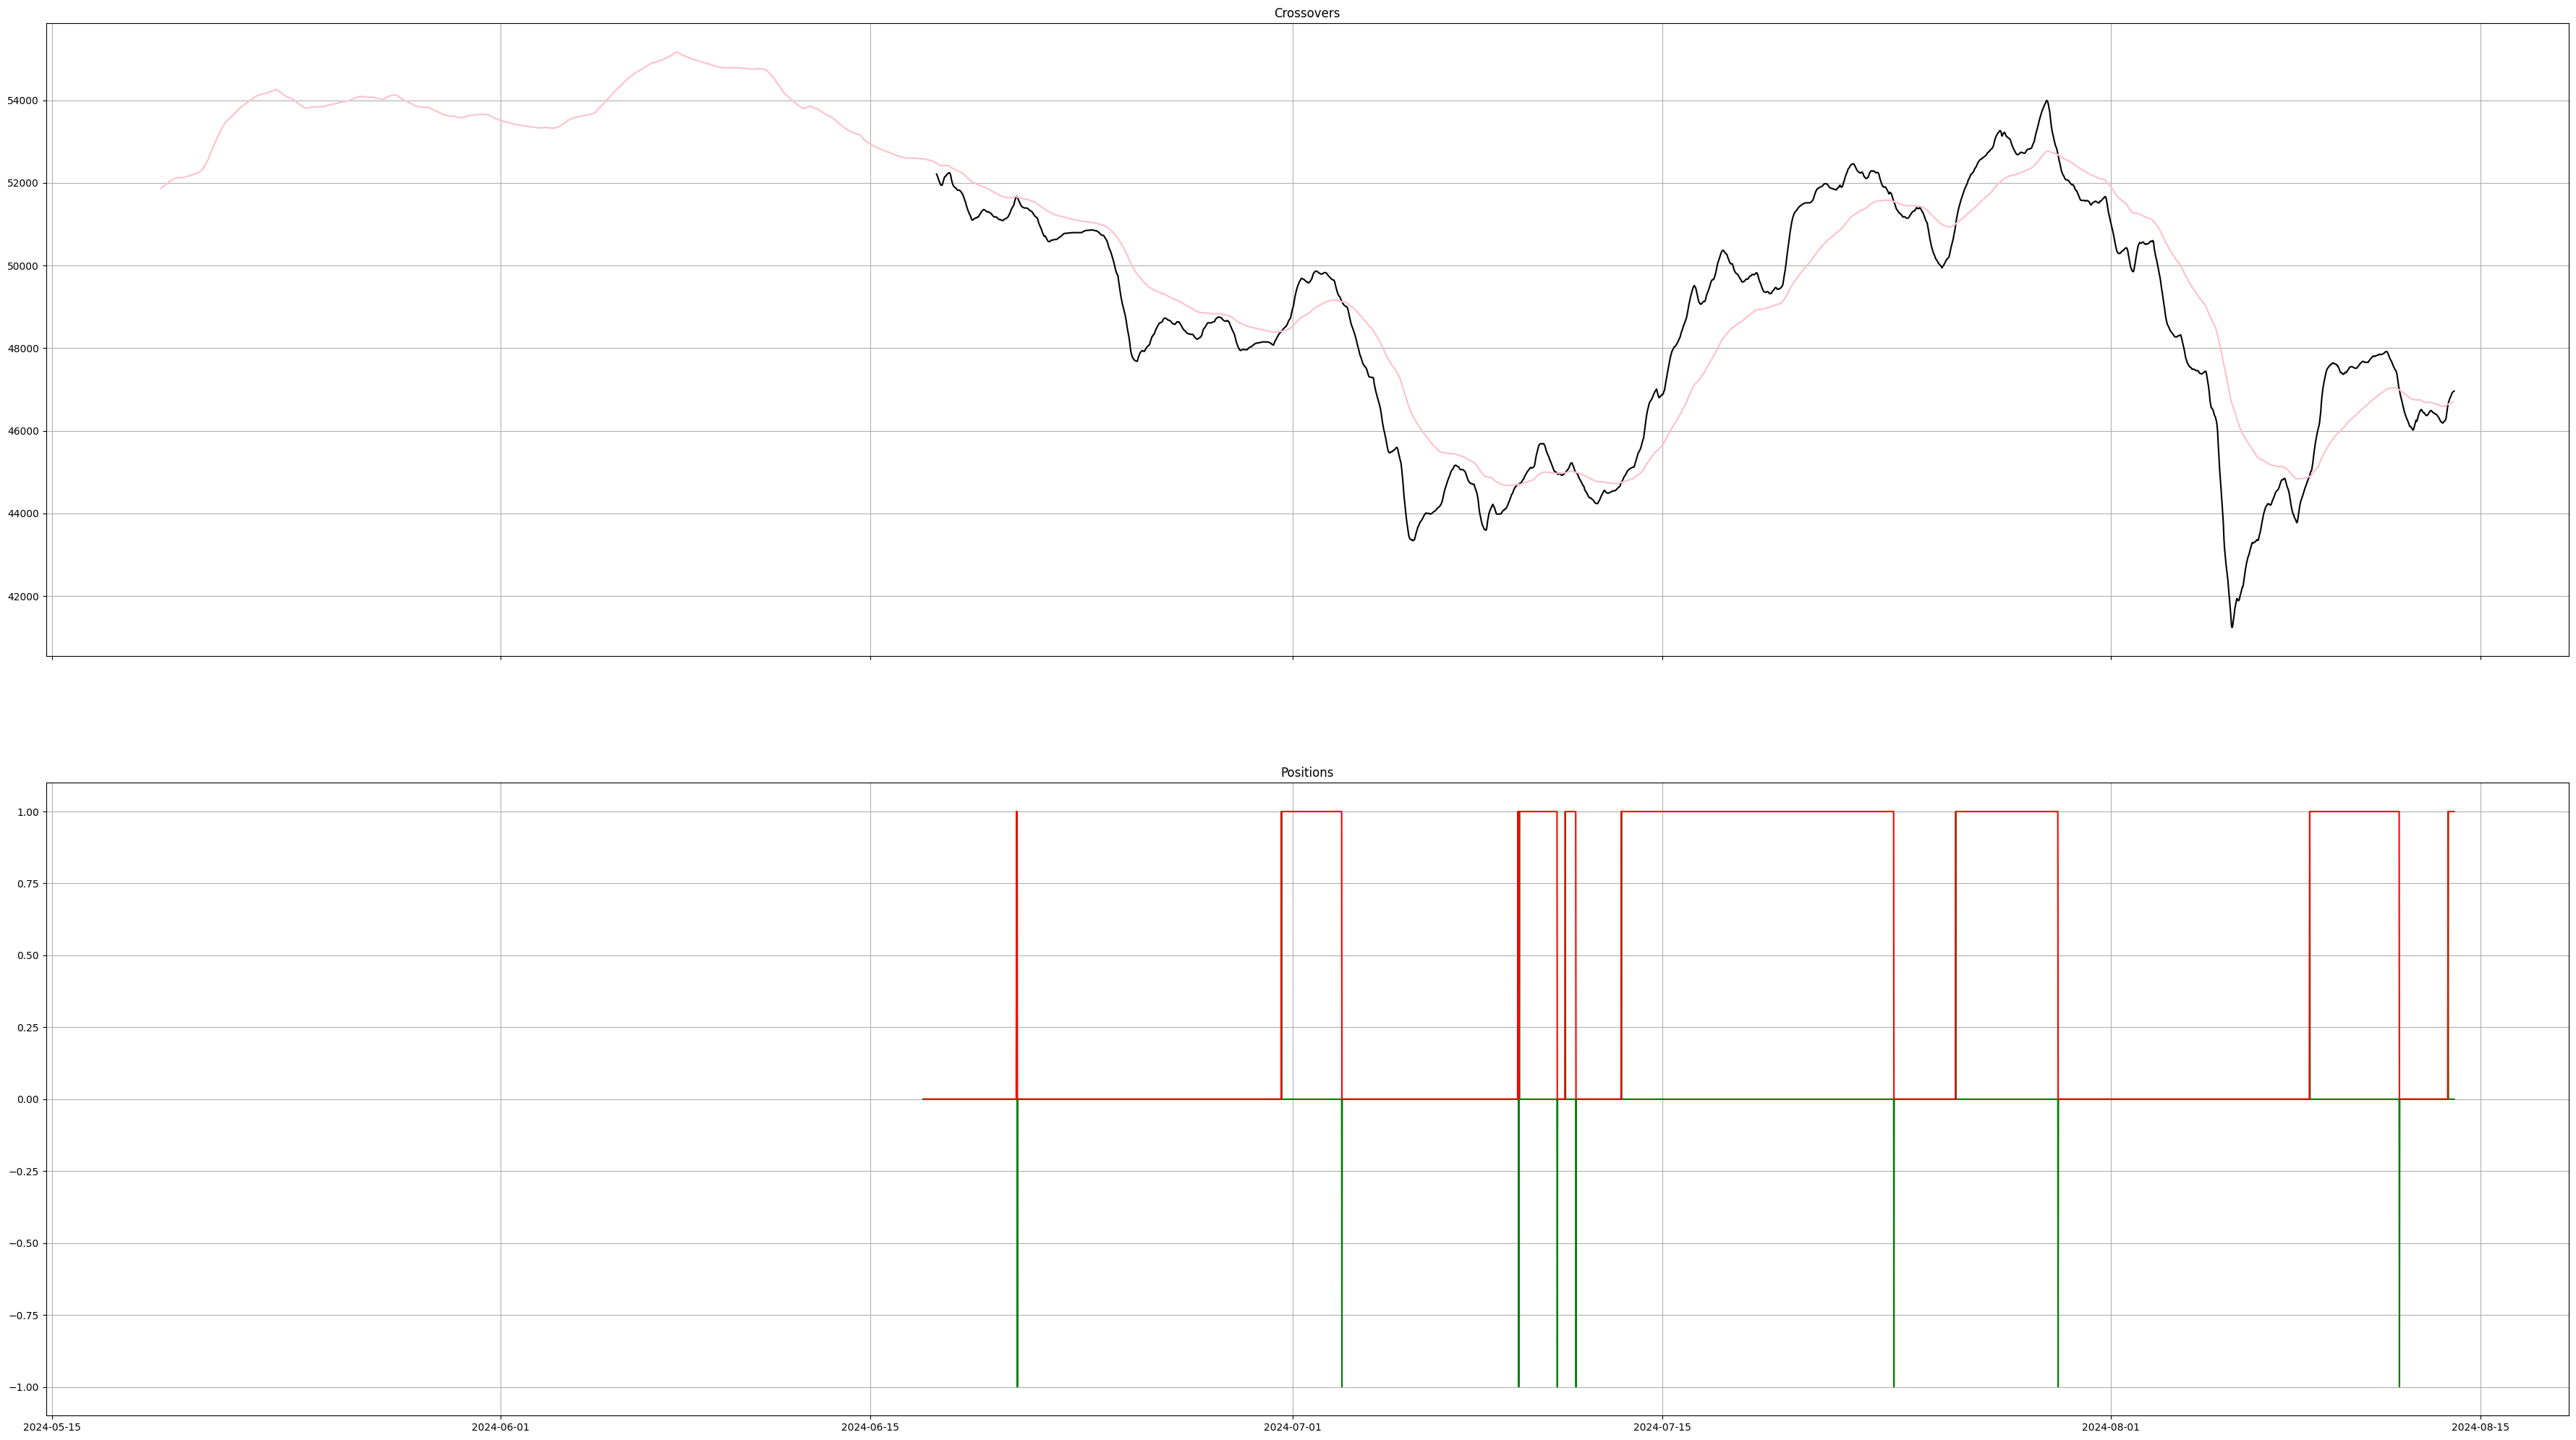

In [713]:
data['Signal'] = 0
data['Applied Position'] = 0
position = 0

for i in data.index:
    if position == 0:
        if (data.at[i, 'EMA'] > long_data.at[data.at[i, 'Hourly Date'], 'Daily EMA']):
            buy_price = data['Close'][i]
            data.at[i, 'Signal'] = 1
            position = 1
            data.at[i, 'Applied Position'] = 1
    else:            
        if (data.at[i, 'EMA'] < long_data.at[data.at[i, 'Hourly Date'], 'Daily EMA']):
            data.at[i, 'Signal'] = 0
            position = 0
            data.at[i, 'Applied Position'] = -1
        else:
            data.at[i, 'Signal'] = 1

figure, axis = plt.subplots(2, sharex=True, figsize=(45, 25))
axis[0].set_title("Crossovers") 
# axis[0].plot(data.index, data['Close'], color='black')
axis[0].plot(data.index, data['EMA'], color='black')
axis[0].plot(long_data.index, long_data['Daily EMA'], color='pink')
axis[0].grid()
axis[1].set_title("Positions") 
axis[1].plot(data.index, data['Applied Position'], color='green')
axis[1].plot(data.index, data['Signal'], color='red')
axis[1].grid()

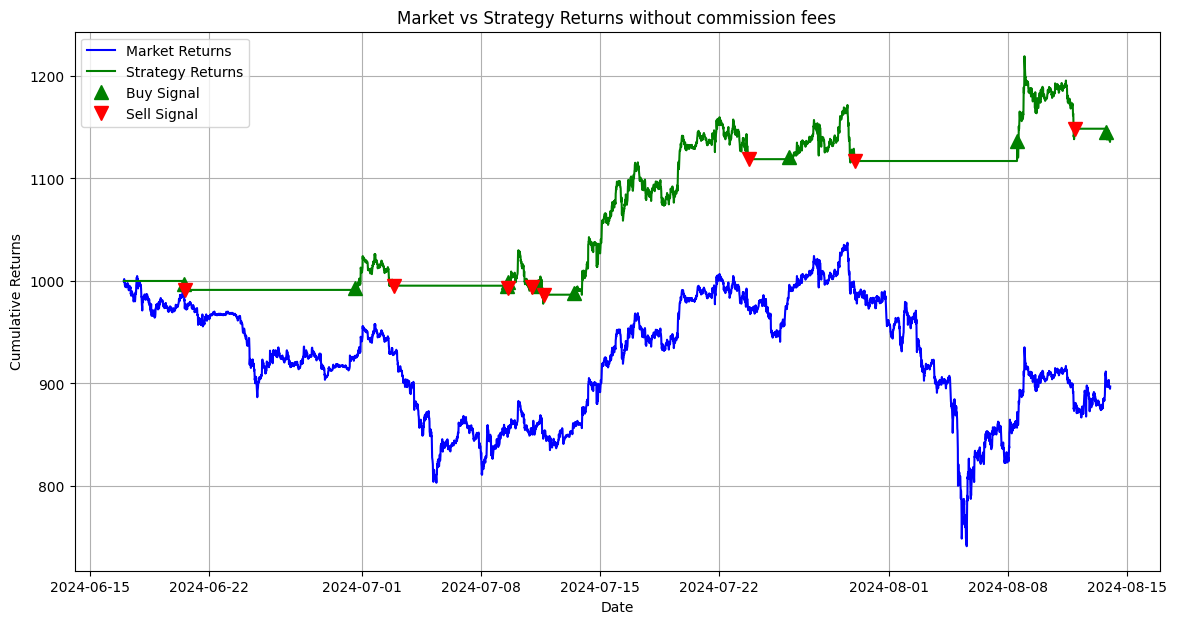

In [714]:
data['Market Returns'] = data['Close'].pct_change()
data['Market Returns'] = data['Market Returns'].fillna(0)
data['Cumulative Market Returns'] = amount_invested*leverage*(1 + data['Market Returns']).cumprod()

data['Strategy Returns'] = data['Market Returns'] * data['Signal']
data['Cumulative Strategy Returns'] = amount_invested*leverage*(1 + (data['Strategy Returns'])).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(data['Cumulative Market Returns'], label='Market Returns', color='b')
plt.plot(data['Cumulative Strategy Returns'], label='Strategy Returns', color='g')
plt.plot(data[data['Applied Position'] == 1].index, data['Cumulative Strategy Returns'][data['Applied Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(data[data['Applied Position'] == -1].index, data['Cumulative Strategy Returns'][data['Applied Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.title('Market vs Strategy Returns without commission fees')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [715]:
print("commissionless cumulative returns: ", data['Cumulative Strategy Returns'].iloc[-1])

commissionless cumulative returns:  1138.4494114409135


In [716]:
cash = amount_invested*leverage
previous_cash = amount_invested*leverage
cummulative_returns = []
data['Cumulative Strategy Returns With Commission'] = 0
position = 0
data['Applied Position'] = 0
data['Trade Type'] = 0
stop_loss = 0

for i in data.index:
    if position == 0:
        if (data.at[i, 'Previous EMA'] < long_data.at[data.at[i, 'Hourly Date'], 'Daily EMA']) and (data.at[i, 'EMA'] > long_data.at[data.at[i, 'Hourly Date'], 'Daily EMA']):
            stop_loss = cash * (1 - stop_loss_ratio)
            position = 1
            previous_cash = cash
            cash = cash * (1 - commission_percentage)
            data.at[i, 'Applied Position'] = 1
    else:            
        cash = cash * (1 + data.at[i, 'Market Returns'])
        if (data.at[i, 'EMA'] < long_data.at[data.at[i, 'Hourly Date'], 'Daily EMA']) or (cash <= stop_loss):
            position = 0
            cash = cash * (1 - commission_percentage)
            longer_crossover_count = 0
            data.at[i, 'Applied Position'] = -1
            if cash < previous_cash:
                data.at[i, 'Trade Type'] = -1
            else:
                data.at[i, 'Trade Type'] = 1
    data.at[i, 'Cumulative Strategy Returns With Commission'] = cash
    if ((amount_invested*leverage) - cash) >= amount_invested:
        print('reached margin at: ', i)
        break
print("Cumulative returns with commission: ", cash)
print("Min Cumulative returns value: ", data['Cumulative Strategy Returns With Commission'].min())

Cumulative returns with commission:  1093.4277273849684
Min Cumulative returns value:  965.7470470631072


/var/folders/9x/c8rnngl93m162n92399m4b6w0000gn/T/ipykernel_53498/2383158683.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '999.0862496536731' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[i, 'Cumulative Strategy Returns With Commission'] = cash


In [717]:
print('closed positions: ', len(data['Trade Type'][data['Trade Type'] == 1]) + len(data['Trade Type'][data['Trade Type'] == -1]))
print('profit positions: ', len(data['Trade Type'][data['Trade Type'] == 1]))
print('loss positions: ', len(data['Trade Type'][data['Trade Type'] == -1]))

closed positions:  7
profit positions:  3
loss positions:  4


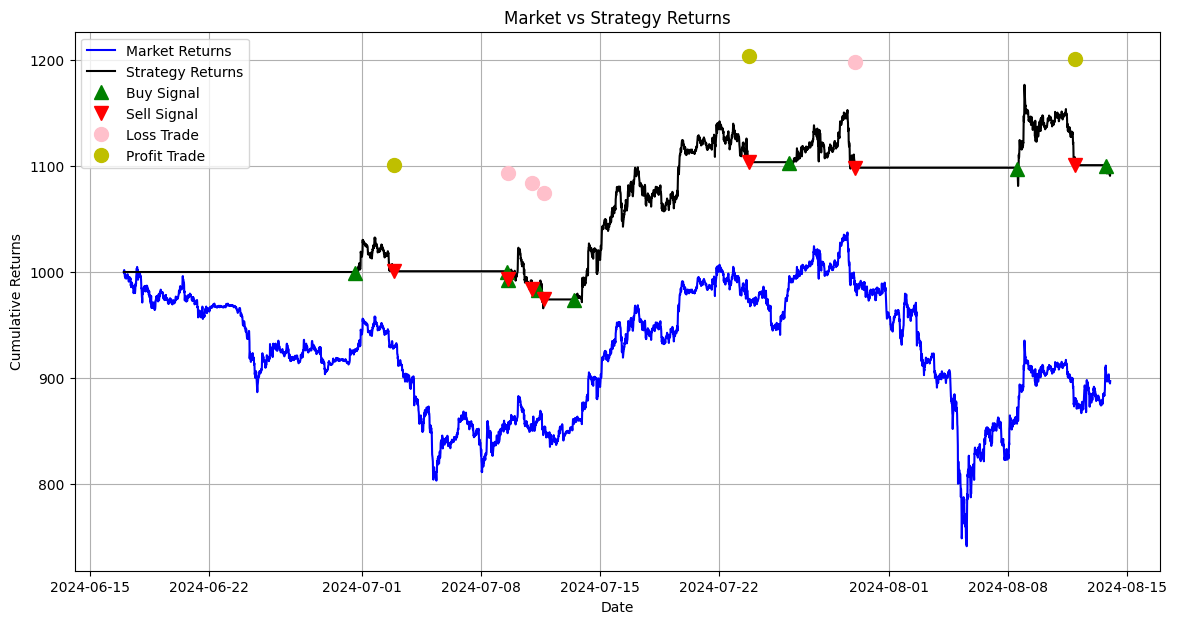

In [718]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Cumulative Market Returns'], label='Market Returns', color='b')
# plt.plot(data.index, cummulative_returns, label='Strategy Returns', color='black')
plt.plot(data['Cumulative Strategy Returns With Commission'], label='Strategy Returns', color='black')
plt.plot(data[data['Applied Position'] == 1].index, data['Cumulative Strategy Returns With Commission'][data['Applied Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(data[data['Applied Position'] == -1].index, data['Cumulative Strategy Returns With Commission'][data['Applied Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.plot(data[data['Trade Type'] == -1].index, (data['Cumulative Strategy Returns With Commission'][data['Trade Type'] == -1]+100), 'o', markersize=10, color='pink', lw=0, label='Loss Trade')
plt.plot(data[data['Trade Type'] == 1].index, (data['Cumulative Strategy Returns With Commission'][data['Trade Type'] == 1]+100), 'o', markersize=10, color='y', lw=0, label='Profit Trade')
plt.title('Market vs Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [719]:
pnl =  data['Cumulative Strategy Returns With Commission'].iloc[-1] - (amount_invested*leverage)
returns = (pnl/amount_invested) * 100
print("pnl: ", pnl)
print("returns %: ", returns)

pnl:  93.42772738496842
returns %:  9.342772738496842


In [726]:
import math
periodic_returns = data['Cumulative Strategy Returns With Commission'].pct_change().dropna()
sharpe_ratio = periodic_returns.mean()/periodic_returns.std()
print("sharpe ratio: ", sharpe_ratio * math.sqrt(252*(60*24)/5))

sharpe ratio:  2.9414858830374557
